In [1]:
from models import Unet_Model, CNN_Model
import time
import numpy as np
import tensorflow as tf

from datetime import datetime
import keras
from keras import layers
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop

2024-10-28 11:05:30.326995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 11:05:30.348715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 11:05:30.360868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 11:05:30.364420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 11:05:30.377400: I tensorflow/core/platform/cpu_feature_guar

# Dataset

In [2]:
def import_data(path):
    x_train = np.load(path + "/x_train.npy")
    x_val = np.load(path + "/x_val.npy")
    x_test = np.load(path + "/x_test.npy")
    y_train = np.load(path + "/y_train.npy")
    y_val = np.load(path + "/y_val.npy")
    y_test = np.load(path + "/y_test.npy")
    z_train = np.load(path + "/z_train.npy")
    z_val = np.load(path + "/z_val.npy")
    z_test = np.load(path + "/z_test.npy")

    return x_train, x_val, x_test, y_train, y_val, y_test, z_train, z_val, z_test

In [3]:
# import dataset
x_train, x_val, x_test, y_train, y_val, y_test, z_train, z_val, z_test = import_data("data128")

# Train Unet

In [4]:
# Model Parameter After Tuning
input_shape = (128,128,1)
init_filter = 16
drop_rate = 0.2
up_sampling = False
regularization = None
batch_norm = False

# Training Parameter
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = "binary_crossentropy"
metrics = ["accuracy"]
epochs = 30

I0000 00:00:1730088411.821430   35133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730088411.845148   35133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730088411.845188   35133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730088411.847243   35133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730088411.847275   35133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
unet = Unet_Model(
    input_shape=input_shape, 
    init_filter=init_filter, 
    drop_rate=drop_rate, 
    up_sampling=up_sampling, 
    regularization=regularization, 
    batch_norm=batch_norm
)

In [6]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32,    │          0 │ conv2d_5[0][0]  

 Total params: 2,206,913 (8.42 MB)

 Trainable params: 2,206,913 (8.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
unet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [8]:
with open("training_output_unet.txt", "a") as f:
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"Test run at {current_time}\n", file=f)

    start_time = time.time()
    results = unet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)
    training_time = time.time() - start_time

    print("Loss", results.history["loss"][0])
    print("Validation loss", results.history["val_loss"][0])

    print(f"Loss: {results.history['loss'][0]}", file=f)
    print(f"Validation loss: {results.history['val_loss'][0]}", file=f)
    print(f"Training time: {training_time}", file=f)

    unet.save("models/UNet_model.h5")

f.close()

Epoch 1/30


I0000 00:00:1730088435.416591   79745 service.cc:146] XLA service 0x7f23b000e480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730088435.416632   79745 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-28 11:07:14.855349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 11:07:15.302032: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1730088449.085247   79745 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 882ms/step - accuracy: 0.7400 - loss: 0.4831 - val_accuracy: 0.9289 - val_loss: 0.3398
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9205 - loss: 0.2583 - val_accuracy: 0.9289 - val_loss: 0.2708
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9184 - loss: 0.2224 - val_accuracy: 0.9289 - val_loss: 0.2184
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9265 - loss: 0.1885 - val_accuracy: 0.9289 - val_loss: 0.1985
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9131 - loss: 0.1994 - val_accuracy: 0.9290 - val_loss: 0.1904
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9231 - loss: 0.1927 - val_accuracy: 0.9372 - val_loss: 0.1952
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9310 - loss: 0.1883 - val_accuracy: 0.9388 - val_loss: 0.1835
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9397 - loss: 0.1662 - val_accuracy: 0.9419 - val_loss: 

Loss 0.3666914701461792
Validation loss 0.33983877301216125


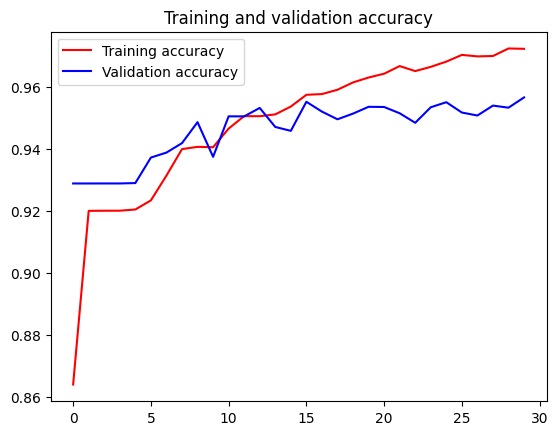

<Figure size 640x480 with 0 Axes>

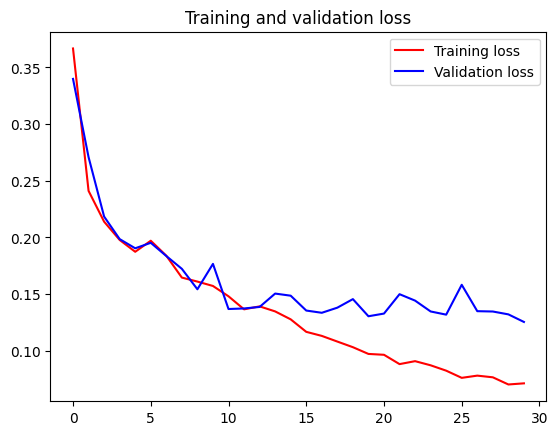

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

# Train CNN

In [10]:
# Model Parameter
input_shape = (128,128,1)
num_layer = 3
num_unit = 64
drop_rate = 0.05

# Training Parameter
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs = 20

In [11]:
cnn = CNN_Model(
    input_shape=input_shape, 
    num_layer=num_layer, 
    num_unit=num_unit, 
    drop_rate=drop_rate
)

In [12]:
cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ concatenate_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 20,296,643 (77.43 MB)

 Trainable params: 1,974,659 (7.53 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [12]:
cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
def encode(x):
    x[x=="normal"] = 0
    x[x=="benign"] = 1
    x[x=="malignant"] = 2
    x = x.astype(int)

    return x

In [14]:
def onehot_encode(x):
    x = encode(x)
    x_onehot = np.zeros((x.size, x.max()+1))
    x_onehot[np.arange(x.size),x] = 1

    return x_onehot

In [15]:
z_train_onehot = onehot_encode(z_train)
z_val_onehot = onehot_encode(z_val)
z_test_onehot = onehot_encode(z_test)

In [16]:
with open("training_output_cnn.txt", "a") as f:
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"Test run at {current_time}\n", file=f)

    masks_train_pred = unet.predict(x_train)
    masks_val_pred = unet.predict(x_val)

    start_time = time.time()
    results = cnn.fit([x_train, masks_train_pred], z_train_onehot, validation_data=([x_val, masks_val_pred], z_val_onehot), epochs=epochs)
    training_time = time.time() - start_time

    start_time = time.time()
    predictions = cnn.predict([x_test, unet.predict(x_test)])
    inference_time = time.time() - start_time

    _, accuracy_val = cnn.evaluate([x_val, unet.predict(x_val)], z_val_onehot, verbose=0)
    _, accuracy_test = cnn.evaluate([x_test, unet.predict(x_test)], z_test_onehot, verbose=0)
    print("Validation accuracy:", accuracy_val)
    print("Test accuracy:", accuracy_test)
    print("Training time", training_time)
    print("Inference time", inference_time)

    print(f"Validation accuracy: {accuracy_val}", file=f)
    print(f"Test accuracy: {accuracy_test}", file=f)
    print(f"Training time: {training_time}", file=f)
    print(f"Inference time: {inference_time}", file=f)

    cnn.save("models/CNN_model.h5")

f.close()

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4976 - loss: 1.3990 - val_accuracy: 0.6282 - val_loss: 0.8775
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7987 - loss: 0.5419 - val_accuracy: 0.8333 - val_loss: 0.6303
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9366 - loss: 0.2012 - val_accuracy: 0.6410 - val_loss: 0.9452
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8415 - loss: 0.3792 - val_accuracy: 0.8077 - val_loss: 0.6203
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9339 - loss: 0.1629 - val_accuracy: 0.8205 - val_loss: 0.7752
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9709 - loss: 0.0998 - val_accuracy: 0.8077 - val_loss: 0.6798
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9858 - loss: 0.0578 - val_accuracy: 0.7564 - val_loss: 0.8083
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━

Validation accuracy: 0.7692307829856873
Test accuracy: 0.8354430198669434
Training time 82.4416971206665
Inference time 20.657909631729126


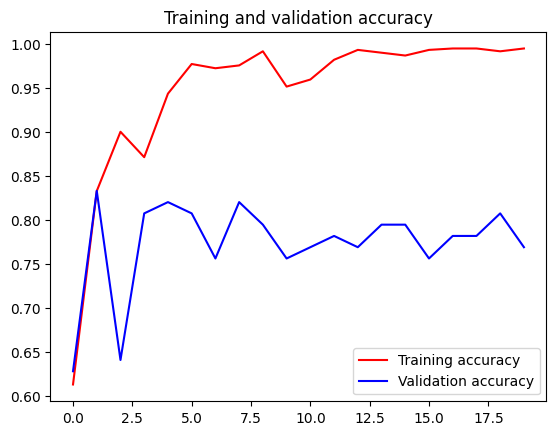

<Figure size 640x480 with 0 Axes>

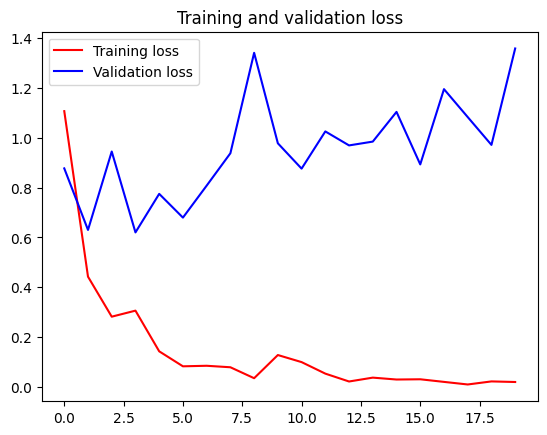

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()